<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Задание

1. Найти в открытых источниках датасет из сферы банки/кредиты, который будет содержать информацию о клиенте и информацию о ранее поступивших платежах
2. Провести разведочный анализ данных и отразить в 3-4 пунктах основные характеристики выборки ( кол-во строк, кол-во параметров, распределение и т.д.)
3. Смоделировать предсказание на период например 1-3 мес ( в зависимости от самой выборки) заплатит человек очередной платеж или нет

# Описание датасетов

Источник: https://www.kaggle.com/competitions/home-credit-default-risk/data

**application_{train|test}.csv**

Это основная таблица, разбитая на два файла для Train (с целью) и Test (без цели).
Статические данные для всех приложений. Одна строка представляет один кредит в нашей выборке данных.

Поскольку основные таблицы содержат достаточное количество данных о клиентах банков с разметкой target, ограничимся только этими двумя таблицами.

# Загрузка и изучение данных

In [43]:
# Импорт библиотек

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
import pickle
import warnings

from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    make_scorer,
    f1_score, 
    precision_score, 
    recall_score, 
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    confusion_matrix
)
from sklearn.model_selection import (
    train_test_split, 
    RandomizedSearchCV
)


warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [2]:
# загрузим датасет с описанием данных
df = pd.read_csv('columns_description.csv', encoding='cp437')

In [3]:
# Загрузим датасет для обучения
application_train = pd.read_csv('application_train.csv')

Далее выведем описание признаков из нашего датасета.

In [4]:
# создадим отдельный датасет
df_description = df[df['Table'] == 'application_{train|test}.csv']

df_description = df_description[['Row', 'Description']]

In [5]:
df_description.sample(10)

,Row,Description
112,FLAG_DOCUMENT_18,Did client provide document 18
91,OBS_30_CNT_SOCIAL_CIRCLE,How many observation of client's social surrou...
120,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...
79,FLOORSMAX_MEDI,Normalized information about building where th...
101,FLAG_DOCUMENT_7,Did client provide document 7
25,FLAG_CONT_MOBILE,"Was mobile phone reachable (1=YES, 0=NO)"
110,FLAG_DOCUMENT_16,Did client provide document 16
76,COMMONAREA_MEDI,Normalized information about building where th...
7,AMT_INCOME_TOTAL,Income of the client
47,YEARS_BUILD_AVG,Normalized information about building where th...


In [6]:
# выведем значение Target
df_description[df_description['Row'] == 'TARGET'].values

array([['TARGET',
        'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)']],
      dtype=object)

Таким образом, значение в столбце TARGET имеет следующее значение:
1 - клиент, испытывающий трудности с оплатой: он/она просрочил платеж более чем на X дней по крайней мере по одному из первых Y платежей по кредиту в нашей выборке, 0 - все остальные случаи.

Можно принять для нашей задачи, что 1 - клиент не выплатил кредит, 0 - клиент выплатил кредит.

In [7]:
#создадим функцию для упрощенного вывода отчета по данным

def mini_report(df):
    print('Head')
    display(df.head())
    print('')
    print('Describe')
    display(df.describe())
    print('')
    print('Info')
    df.info()
    print('')
    print('Пропуски')
    display(pd.DataFrame(application_train.isna().sum())
            .sort_values(by=0, ascending=False))

In [8]:
# выведем отчет по трейну
mini_report(application_train)

Head


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


Describe


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97


Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB

Пропуски


,0
COMMONAREA_MEDI,214865
COMMONAREA_AVG,214865
COMMONAREA_MODE,214865
NONLIVINGAPARTMENTS_MODE,213514
NONLIVINGAPARTMENTS_AVG,213514
...,...
NAME_HOUSING_TYPE,0
NAME_FAMILY_STATUS,0
NAME_EDUCATION_TYPE,0
NAME_INCOME_TYPE,0


В представленных данных много незаполненных столбцов. Такое может возникнуть при неккоректном сборе данных или при неудачном слиянии нескольких таблиц. От этих признаков принято избавиться в дальнейшем.

Далее посмотрим на характер распределения некоторых признаков.

Интересно посмотреть на следующие численные признаки:

- AMT_INCOME_TOTAL - Доход клиента
- AMT_CREDIT - Сумма кредита
- AMT_ANNUITY - Сумма ежемесячного платежа
- AMT_GOODS_PRICE - Для потребительских кредитов это цена товара, на который предоставляется кредит

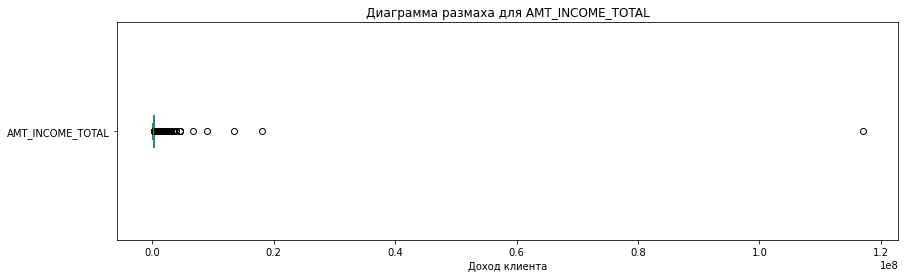

In [9]:
#выведем диаграмму boxplot
application_train['AMT_INCOME_TOTAL'].plot(kind='box', vert=False, figsize=(14,4))

plt.xlabel('Доход клиента')
plt.title('Диаграмма размаха для AMT_INCOME_TOTAL');

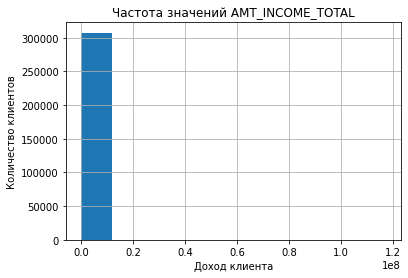

In [10]:
#выведем частотную диаграмму
application_train['AMT_INCOME_TOTAL'].hist()

plt.xlabel('Доход клиента')
plt.ylabel('Количество клиентов')
plt.title('Частота значений AMT_INCOME_TOTAL');

Несколько значений сильно выбиваются из выборки. Можно их удалить для улучшения обучения модели.

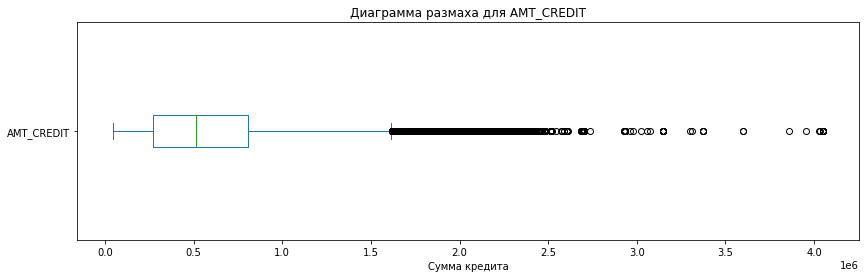

In [11]:
#выведем диаграмму boxplot
application_train['AMT_CREDIT'].plot(kind='box', vert=False, figsize=(14,4))

plt.xlabel('Сумма кредита')
plt.title('Диаграмма размаха для AMT_CREDIT'); 

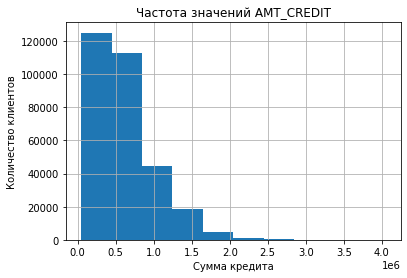

In [12]:
#выведем частотную диаграмму
application_train['AMT_CREDIT'].hist()

plt.xlabel('Сумма кредита')
plt.ylabel('Количество клиентов')
plt.title('Частота значений AMT_CREDIT');

Распределение значений в признаке "Сумма кредита" можно оставить как есть. Выбросы есть, но не сильно выбивающиеся из общего распределения.

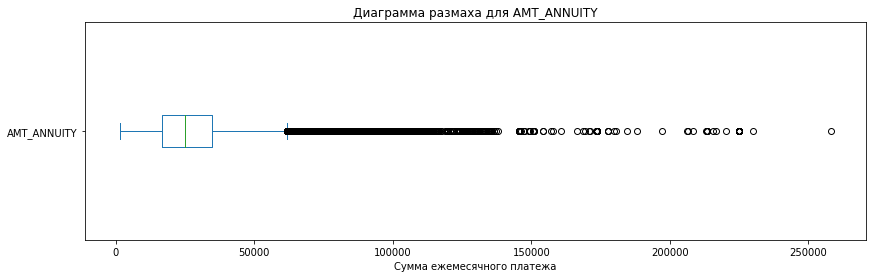

In [13]:
#выведем диаграмму boxplot
application_train['AMT_ANNUITY'].plot(kind='box', vert=False, figsize=(14,4))

plt.xlabel('Сумма ежемесячного платежа')
plt.title('Диаграмма размаха для AMT_ANNUITY'); 

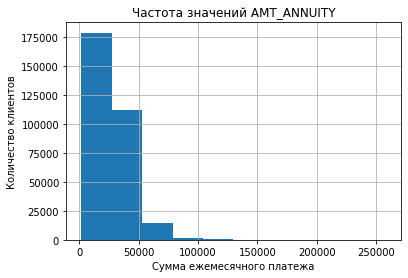

In [14]:
#выведем частотную диаграмму
application_train['AMT_ANNUITY'].hist()

plt.xlabel('Сумма ежемесячного платежа')
plt.ylabel('Количество клиентов')
plt.title('Частота значений AMT_ANNUITY');

Этот признак тоже можно оставить, как есть.

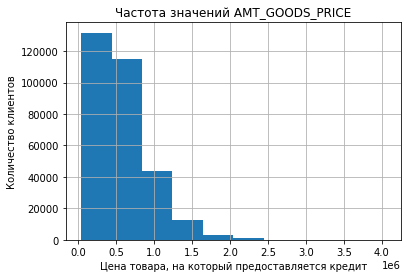

In [15]:
#выведем частотную диаграмму
application_train['AMT_GOODS_PRICE'].hist()

plt.xlabel('Цена товара, на который предоставляется кредит')
plt.ylabel('Количество клиентов')
plt.title('Частота значений AMT_GOODS_PRICE');

Значения в столбце "Цена товара, на который предоставляется кредит" тоже выглядит логично.

# Предобработка данных

In [16]:
# удалим выбросы
application_train = application_train[application_train['AMT_INCOME_TOTAL']<4000000]

Ранее было обнаружено, что в данных много столбцов с пропущенными значениями - около половины данных. Посмотрим на количество пропусков подробнее.

In [17]:
# сохраним таблицу с количеством пропусков
t = pd.DataFrame(application_train.isna().sum()).sort_values(by=0, ascending=False)
t

,0
COMMONAREA_MEDI,214857
COMMONAREA_AVG,214857
COMMONAREA_MODE,214857
NONLIVINGAPARTMENTS_MODE,213506
NONLIVINGAPARTMENTS_AVG,213506
...,...
NAME_HOUSING_TYPE,0
NAME_FAMILY_STATUS,0
NAME_EDUCATION_TYPE,0
NAME_INCOME_TYPE,0


Далее удалим признаки, где поличество пропущенных значений превышает 100000.

In [18]:
# сохраним в список 
col_to_drop = t[t[0]>100000].index.to_list()
print(col_to_drop)

['COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MEDI', 'FONDKAPREMONT_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI', 'FLOORSMIN_AVG', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE', 'YEARS_BUILD_AVG', 'OWN_CAR_AGE', 'LANDAREA_MEDI', 'LANDAREA_MODE', 'LANDAREA_AVG', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MODE', 'EXT_SOURCE_1', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'ELEVATORS_MEDI', 'ELEVATORS_AVG', 'ELEVATORS_MODE', 'WALLSMATERIAL_MODE', 'APARTMENTS_MEDI', 'APARTMENTS_AVG', 'APARTMENTS_MODE', 'ENTRANCES_MEDI', 'ENTRANCES_AVG', 'ENTRANCES_MODE', 'LIVINGAREA_AVG', 'LIVINGAREA_MODE', 'LIVINGAREA_MEDI', 'HOUSETYPE_MODE', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI', 'FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_AVG', 'TOTALAREA_MODE', 'EMERGENCYSTATE_MODE

Заполнение пропусков - достаточно кропотливая работа. В данном случае, пожертвуем количеством данных, сохранив как можно больше признаков. Все пропуски будут просто удалены.

In [19]:
# удалим из датасетов пустые признаки
df_train = application_train.drop(col_to_drop, axis=1)

In [20]:
# удалим пропуски в строках
df_train = df_train.dropna()

In [21]:
# посмотрим на то, что осталось
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167726 entries, 0 to 307510
Data columns (total 73 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   167726 non-null  int64  
 1   TARGET                       167726 non-null  int64  
 2   NAME_CONTRACT_TYPE           167726 non-null  object 
 3   CODE_GENDER                  167726 non-null  object 
 4   FLAG_OWN_CAR                 167726 non-null  object 
 5   FLAG_OWN_REALTY              167726 non-null  object 
 6   CNT_CHILDREN                 167726 non-null  int64  
 7   AMT_INCOME_TOTAL             167726 non-null  float64
 8   AMT_CREDIT                   167726 non-null  float64
 9   AMT_ANNUITY                  167726 non-null  float64
 10  AMT_GOODS_PRICE              167726 non-null  float64
 11  NAME_TYPE_SUITE              167726 non-null  object 
 12  NAME_INCOME_TYPE             167726 non-null  object 
 13  NAME

Данные подготовлены, можно приступать к обучению.

# Анализ данных

TARGET
0    0.915302
1    0.084698
Name: proportion, dtype: float64


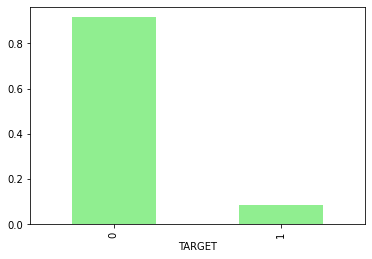

In [22]:
#исследуем баланс классов

#относительная частота значений от 0 до 1
class_frequency = df_train['TARGET'].value_counts(normalize=True)

#выведем относительное количество данных в двух классах
print(class_frequency)

#для наглядности выведем диаграмму
class_frequency.plot(kind='bar', color='lightgreen');

В данных наблюдается сильный дисбаланс классов. Это нужно учесть при обучении модели.

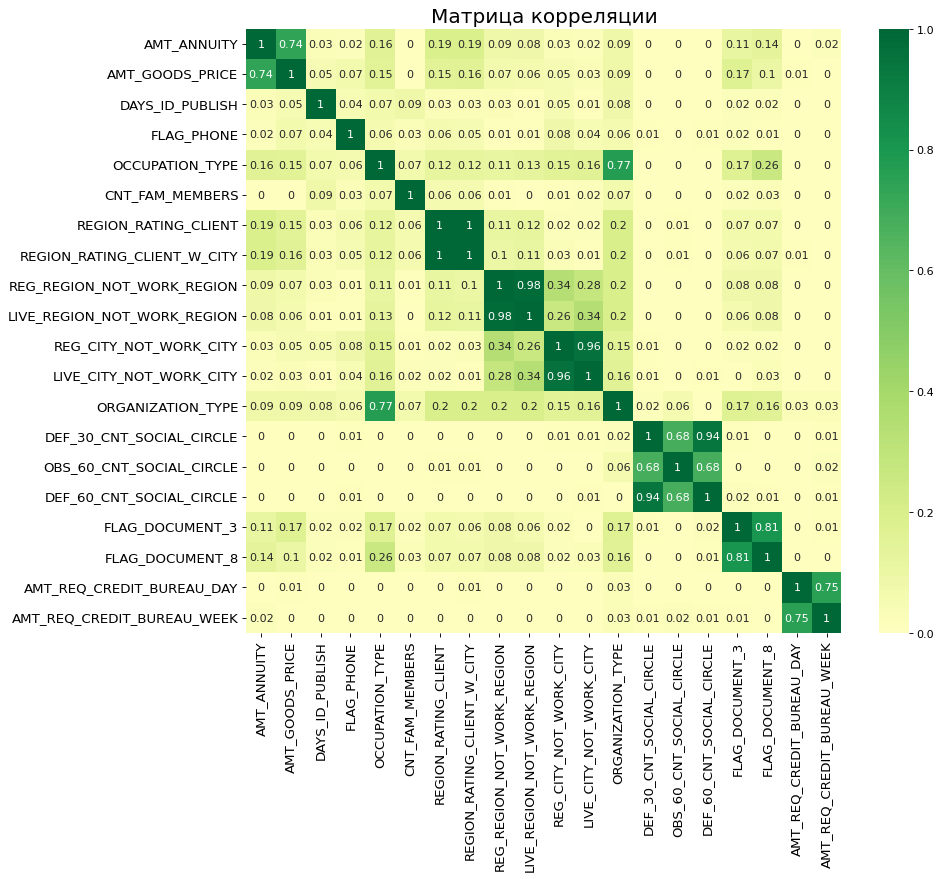

In [23]:
# зададим матрицу корреляции
corr_matrix = df_train.phik_matrix(verbose=False).round(2)

# выберем верхний треугольник матрицы
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# найдем индексы признаков с корреляцией больше 0.5
high_corr = [column for column in upper.columns if any(upper[column] > 0.5)]

# отрисуем полученную матрицу
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(df_train[high_corr].phik_matrix(verbose=False).round(2), 
            xticklabels=df_train[high_corr].phik_matrix(verbose=False).columns, 
            yticklabels=df_train[high_corr].phik_matrix(verbose=False).columns, 
            cmap='RdYlGn', 
            center=0, 
            annot=True)

plt.title('Матрица корреляции', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Между признаками достаточно слабая корреляция. Корреляция есть среди признаков, которые логически связаны или получены путем вывода одного из другого. Таргет вообще не вошел в матрицу.

Рассмотрим пару демографических признаков.

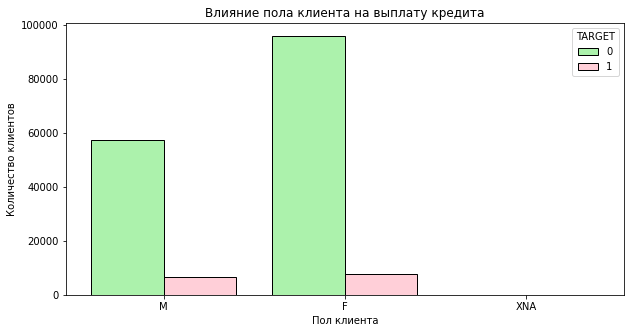

In [24]:
#зададим размер диаграммы
plt.figure(figsize=(10,5))

#зададим параметры диаграммы
sns.histplot(data=df_train, 
             x='CODE_GENDER', 
             hue='TARGET', 
             multiple='dodge', 
             palette = ('lightgreen', 'pink'), 
             shrink=.8)

plt.xlabel('Пол клиента')
plt.ylabel('Количество клиентов')
plt.title('Влияние пола клиента на выплату кредита');

Пол клиента не сильно влияет на факт выплаты кредита. В целом, мужчины чаще не выплачивают кредит.

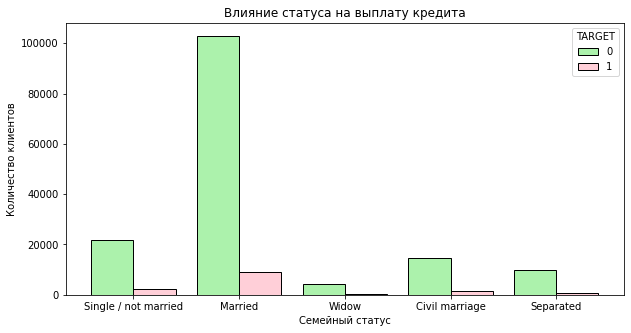

In [25]:
#зададим размер диаграммы
plt.figure(figsize=(10,5))

#зададим параметры диаграммы
sns.histplot(data=df_train, 
             x='NAME_FAMILY_STATUS', 
             hue='TARGET', 
             multiple='dodge', 
             palette = ('lightgreen', 'pink'), 
             shrink=.8)

plt.xlabel('Семейный статус')
plt.ylabel('Количество клиентов')
plt.title('Влияние статуса на выплату кредита');

Однозначно можно сказать, что семейные клиенты чаще берут кредиты. И непогашенных кредитов у них больше.

# Обучение модели

In [26]:
# разделим выборку

X = df_train.drop("TARGET", axis=1)
y = df_train["TARGET"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, shuffle=True, test_size=0.25, 
    stratify=y, random_state=42)

In [27]:
#посмотрим на результат деления
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(125794, 72)
(125794,)
(41932, 72)
(41932,)


In [28]:
#создадим список категориальных признаков
cat_features = X_train.select_dtypes(include='object').columns.to_list()
print(cat_features)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']


In [29]:
#зададим метрики, которые будут вычисляться для всех моделей
scorers = {
    'roc_auc_score': make_scorer(roc_auc_score, needs_proba=True),
    'f1_score': make_scorer(f1_score),
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score)
}

Далее подберем гиперпараметры для модели. Для случая кредитного риска, важно получить модель, которая бы хорошо предсказывала положительный класс (клиент не выплатил кредит) -  то есть долю объектов, названных классификатором положительными и при этом действительно являющимися положительными. Поэтому в качестве метрики для подбора параметром будем использовать Precision.

In [30]:
# определим параметры для оптимизации
param_search = {'learning_rate': [0.01, 0.02, 0.1, 0.2],
             'max_depth': [2, 6, 8]}

#задаим постоянные параметры для модели CatBoost
params_cb = {'loss_function': 'Logloss',
             'eval_metric':  'Precision',
             'cat_features': cat_features,
             'auto_class_weights': 'Balanced',
              'n_estimators': 500,
              'random_seed': 42,
              'verbose': 100}

clf = CatBoostClassifier(**params_cb)

#определим модель
gs_cb = RandomizedSearchCV(estimator=clf, 
                       cv=3, 
                       param_distributions=param_search,  
                       refit='precision_score',
                       random_state=42,
                       scoring=scorers)

gs_cb.fit(X_train, y_train, eval_set=(X_valid, y_valid))

gs_cb_best_score = gs_cb.best_score_ 
gs_cb_best_params = gs_cb.best_params_
print(f'best_score: {gs_cb_best_score}')
print(f'best_params: {gs_cb_best_params}')

0:	learn: 0.6468595	test: 0.6421657	best: 0.6421657 (0)	total: 405ms	remaining: 3m 22s
100:	learn: 0.7240580	test: 0.6933901	best: 0.6946323 (93)	total: 19.3s	remaining: 1m 16s
200:	learn: 0.7679797	test: 0.7012676	best: 0.7012676 (200)	total: 40.2s	remaining: 59.8s
300:	learn: 0.7989636	test: 0.7067557	best: 0.7075407 (280)	total: 59.5s	remaining: 39.3s
400:	learn: 0.8249201	test: 0.7129002	best: 0.7132200 (381)	total: 1m 18s	remaining: 19.4s
499:	learn: 0.8436376	test: 0.7189481	best: 0.7189481 (499)	total: 1m 37s	remaining: 0us

bestTest = 0.7189480576
bestIteration = 499

0:	learn: 0.6561139	test: 0.6500058	best: 0.6500058 (0)	total: 206ms	remaining: 1m 42s
100:	learn: 0.7308563	test: 0.6982365	best: 0.6982365 (100)	total: 18.7s	remaining: 1m 14s
200:	learn: 0.7697312	test: 0.7025957	best: 0.7040214 (178)	total: 37.6s	remaining: 55.9s
300:	learn: 0.8012271	test: 0.7074838	best: 0.7079645 (288)	total: 1m 11s	remaining: 47s
400:	learn: 0.8251831	test: 0.7125476	best: 0.7140738 (389)	

499:	learn: 0.7289220	test: 0.6948218	best: 0.6955574 (475)	total: 2m 4s	remaining: 0us

bestTest = 0.695557431
bestIteration = 475

Shrink model to first 476 iterations.
0:	learn: 0.6571675	test: 0.6445473	best: 0.6445473 (0)	total: 302ms	remaining: 2m 30s
100:	learn: 0.6944565	test: 0.6776560	best: 0.6776948 (99)	total: 23.1s	remaining: 1m 31s
200:	learn: 0.7076701	test: 0.6851282	best: 0.6851642 (199)	total: 46.9s	remaining: 1m 9s
300:	learn: 0.7165718	test: 0.6902001	best: 0.6902001 (300)	total: 1m 10s	remaining: 46.3s
400:	learn: 0.7230776	test: 0.6934717	best: 0.6935013 (398)	total: 1m 31s	remaining: 22.6s
499:	learn: 0.7306299	test: 0.6968917	best: 0.6968917 (499)	total: 1m 53s	remaining: 0us

bestTest = 0.6968917337
bestIteration = 499

0:	learn: 0.6468828	test: 0.6421657	best: 0.6421657 (0)	total: 255ms	remaining: 2m 7s
100:	learn: 0.6798763	test: 0.6693127	best: 0.6693544 (99)	total: 25.7s	remaining: 1m 41s
200:	learn: 0.6912874	test: 0.6788093	best: 0.6788093 (200)	total: 52

0:	learn: 0.6468595	test: 0.6421657	best: 0.6421657 (0)	total: 196ms	remaining: 1m 38s
100:	learn: 0.7010704	test: 0.6885157	best: 0.6887147 (99)	total: 18.2s	remaining: 1m 12s
200:	learn: 0.7280686	test: 0.6963851	best: 0.6965097 (198)	total: 37.3s	remaining: 55.5s
300:	learn: 0.7520912	test: 0.7006509	best: 0.7007366 (298)	total: 56.3s	remaining: 37.2s
400:	learn: 0.7720275	test: 0.7055020	best: 0.7055020 (400)	total: 1m 15s	remaining: 18.6s
499:	learn: 0.7890856	test: 0.7095505	best: 0.7099483 (476)	total: 1m 34s	remaining: 0us

bestTest = 0.7099482625
bestIteration = 476

Shrink model to first 477 iterations.
0:	learn: 0.6561139	test: 0.6500058	best: 0.6500058 (0)	total: 202ms	remaining: 1m 40s
100:	learn: 0.7053647	test: 0.6905945	best: 0.6905945 (100)	total: 18.3s	remaining: 1m 12s
200:	learn: 0.7334615	test: 0.6991300	best: 0.7001224 (196)	total: 38.1s	remaining: 56.7s
300:	learn: 0.7562919	test: 0.7035565	best: 0.7037970 (297)	total: 57.4s	remaining: 38s
400:	learn: 0.7763282	t

In [31]:
#зададим функцию для вывода интересующих метрик

def results_gm(model):
    
    results = pd.DataFrame(model.cv_results_)
    table_results = (results[['mean_test_f1_score', 'mean_test_roc_auc_score', 
                    'mean_test_precision_score', 'mean_test_recall_score']].round(3).head(5)
                     .sort_values(by='mean_test_precision_score', ascending=False))
    
    return table_results

In [32]:
#сохраним результаты в таблице и выведем результаты
tadle_results_cb = results_gm(gs_cb)

tadle_results_cb

,mean_test_f1_score,mean_test_roc_auc_score,mean_test_precision_score,mean_test_recall_score
3,0.295,0.739,0.212,0.487
0,0.286,0.733,0.196,0.528
4,0.282,0.755,0.179,0.659
1,0.280,0.757,0.177,0.668
2,0.268,0.742,0.167,0.670


Далее попробуем немного улучишить модель.

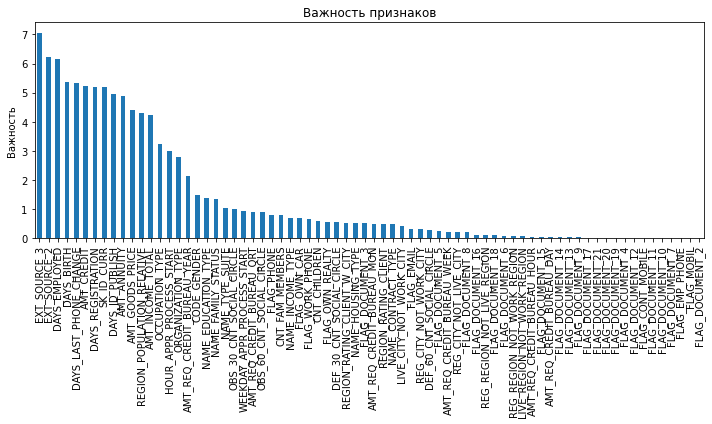

In [33]:
#Выведем диаграмму с оценкой влияния признаков на целевой
imp = pd.Series(gs_cb.best_estimator_.feature_importances_,
               X_train.columns)

fig, ax = plt.subplots(figsize=(10,6))
imp.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

In [34]:
# выберем наиболее значимые признаки
top_features = imp.sort_values(ascending=False).head(50).index.to_list()
print(top_features)

['EXT_SOURCE_3', 'EXT_SOURCE_2', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE', 'AMT_CREDIT', 'DAYS_REGISTRATION', 'SK_ID_CURR', 'DAYS_ID_PUBLISH', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'AMT_INCOME_TOTAL', 'OCCUPATION_TYPE', 'HOUR_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_TYPE_SUITE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'WEEKDAY_APPR_PROCESS_START', 'AMT_REQ_CREDIT_BUREAU_QRT', 'OBS_60_CNT_SOCIAL_CIRCLE', 'FLAG_PHONE', 'CNT_FAM_MEMBERS', 'NAME_INCOME_TYPE', 'FLAG_OWN_CAR', 'FLAG_WORK_PHONE', 'CNT_CHILDREN', 'FLAG_OWN_REALTY', 'DEF_30_CNT_SOCIAL_CIRCLE', 'REGION_RATING_CLIENT_W_CITY', 'NAME_HOUSING_TYPE', 'FLAG_DOCUMENT_3', 'AMT_REQ_CREDIT_BUREAU_MON', 'REGION_RATING_CLIENT', 'NAME_CONTRACT_TYPE', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_EMAIL', 'REG_CITY_NOT_WORK_CITY', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_5', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'REG_CITY_NOT_LIVE_CITY', 

In [35]:
# отредактируем выборку
X_train_top = X_train[top_features]
X_valid_top = X_valid[top_features]

In [36]:
#создадим список категориальных признаков
cat_features_top = X_train_top.select_dtypes(include='object').columns.to_list()
print(cat_features_top)

['OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_TYPE_SUITE', 'WEEKDAY_APPR_PROCESS_START', 'NAME_INCOME_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_HOUSING_TYPE', 'NAME_CONTRACT_TYPE']


In [37]:
#задаим постоянные параметры для модели CatBoost

param = {'learning_rate': 0.2,
             'max_depth': 8,
             'loss_function': 'Logloss',
             'eval_metric':  'Precision',
             'cat_features': cat_features_top,
             'auto_class_weights': 'Balanced',
              'n_estimators': 500,
              'random_seed': 42}

clf = CatBoostClassifier(**param)


clf.fit(X_train_top, y_train, eval_set=(X_valid_top, y_valid), verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Судя по графику, модель переобучается. Метрика на тесте немного падает, по сравнению с показателями при обучении. Возможно, необходимо ограничить глубину дерева.

In [44]:
with open('model_risk.pcl', 'bw') as fid:
    pickle.dump(clf, fid)  

In [38]:
# получим предсказание модели
predicted_valid = clf.predict(X_valid_top)

# вычислим вероятность положительного класса для всех моделей
probabilities = clf.predict_proba(X_valid_top)

#вычислим значение auc_roc
auc_roc_test = roc_auc_score(y_valid, probabilities[:, 1])

print('AUC_ROC при тестировании:',"%.2f" % auc_roc_test)
print("F1 при тестировании:", "%.2f" % f1_score(y_valid, predicted_valid))
print("Точность при тестировании:", "%.2f" % precision_score(y_valid, predicted_valid))
print("Полнота при тестировании:", "%.2f" % recall_score(y_valid, predicted_valid))

AUC_ROC при тестировании: 0.72
F1 при тестировании: 0.28
Точность при тестировании: 0.21
Полнота при тестировании: 0.44


In [39]:
# выведем матрицу ошибок
conf_matrix = pd.DataFrame(confusion_matrix(y_valid, predicted_valid), 
                           index = ['actual 0', 'actual 1'], 
                           columns = ['predicted 0', 'predicted 1'])
conf_matrix

,predicted 0,predicted 1
actual 0,32446,5934
actual 1,1983,1569


Судя по матрице ошибок, положительный класс предсказывается не точно, что может быть критичным для компании. Однако, в целом качество предсказаний неплохое.

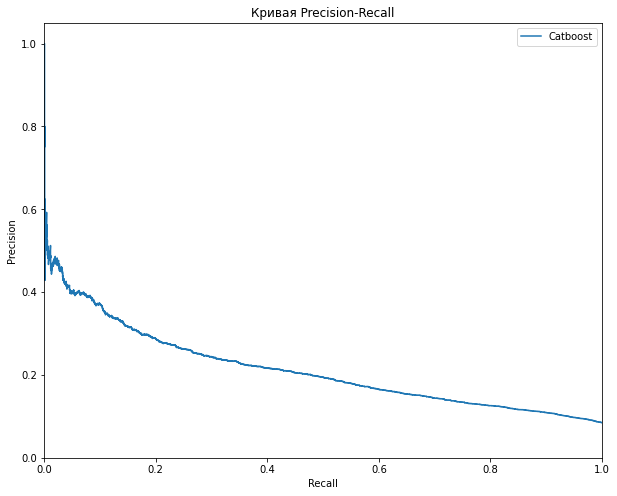

In [40]:
# вычислим значения точности, полноты и порога
precision, recall, thresholds = precision_recall_curve(y_valid, 
                                                       probabilities[:, 1])
# выведем графики изменения кривых по мере изменения порога 
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, linestyle='-', label='Catboost')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

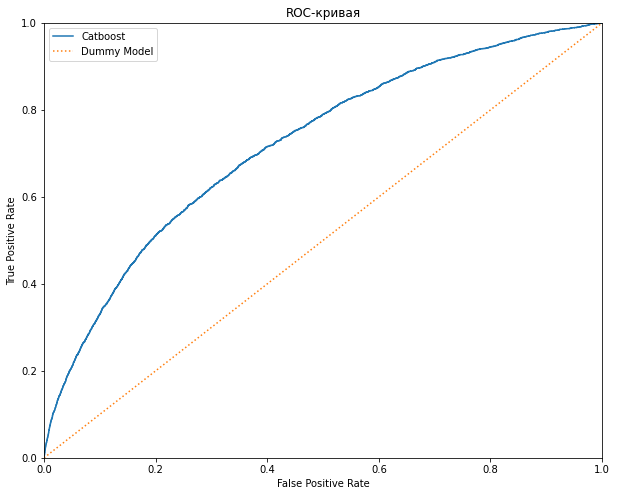

In [41]:
# посмотрим на кривую ошибок при изменении порога классификации
# вычислим значения ошибок и порога
fpr, tpr, thresholds = roc_curve(y_valid, probabilities[:, 1])

# выведем графики кривой ошибок для всех моделей
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linestyle='-', label='Catboost')
plt.plot([0, 1], [0, 1], linestyle=':', label='Dummy Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC-кривая')
plt.show()

Судя по характеру кривой ошибок и площади под кривой, качество предсказаний для модели на валидационных данных неплохое в целом.

# Выводы

В результате выполнены следующие задачи:
1. найдены данные, подходящие для классификации кредитного риска;
2. данные грубо предобработанны и проведен небольшой анализ;
3. обучена модель, которая предсказывает кредитный риск клиента:
    - AUC_ROC при тестировании: 0.72
    - F1 при тестировании: 0.28
    - Точность при тестировании: 0.21
    - Полнота при тестировании: 0.44
    
Для повышения точности модели можно попробовать следующие действия:
1. использовать все данные, доступные в источнике;
2. тщательнее предобработать данные, сохранив более 95%;
3. попробовать использовать другую модель.